## 09. 한글 텍스트 처리 - 네이버 영화 평점 감성 분석

#### 한글 NLP 처리
한글은 '띄어쓰기'와 '다양한 조사' 때문에 텍스트 분석이 더욱 어렵다. 띄어쓰기를 잘못하면 의미가 왜곡될 수 있고, 조사의 경우의 수가 많기 때문이다. 

KoNLPy는 대표적인 한글 형태소 패키지이다. 

#### 실습
참고자료 : 네이버 영화 평점 데이터
 https://github.com/e9t/nsmc

In [1]:
import pandas as pd

train_df = pd.read_csv('data/naver-movie/ratings_train.txt', sep='\t')
train_df.head(3)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0


In [3]:
#긍정과 부정의 비율. 1이 긍정, 0이 부정
train_df['label'].value_counts()

0    75173
1    74827
Name: label, dtype: int64

In [5]:
import re

#Null을 공백으로
train_df = train_df.fillna(' ')
#정규표현식을 이용해 숫자를 공백으로
train_df['document'] = train_df['document'].apply(lambda x: re.sub(r"\d+"," ",x))

In [6]:
#테스트 데이터도 동일하게 수행
test_df = pd.read_csv('data/naver-movie/ratings_test.txt', sep='\t')
test_df = test_df.fillna(' ')
test_df['document'] = test_df['document'].apply(lambda x: re.sub(r"\d+"," ",x))

In [7]:
#id 칼럼 삭제
train_df.drop('id',axis=1, inplace=True)
test_df.drop('id',axis=1, inplace=True)

In [8]:
#sns분석에 적합한 twitter 형태소 분석기를 이용해 형태소 단위로 토큰화
from konlpy.tag import Twitter

twitter = Twitter()
def tw_tokenizer(text):
    tokens_ko = twitter.morphs(text)
    return tokens_ko

C:\ProgramData\Anaconda3\lib\site-packages\konlpy\tag\_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [10]:
#tfidf 벡터화
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

#토큰나이저 넣어서 벡터화 진행
tfidf_vect = TfidfVectorizer(tokenizer = tw_tokenizer, ngram_range = (1,2), min_df = 3, max_df = 0.9)
tfidf_vect.fit(train_df['document'])
tfidf_matrix_train = tfidf_vect.transform(train_df['document'])

In [12]:
#로지스틱 회귀를 이용해 분류 기반 감성 분석
lg_clf = LogisticRegression(random_state = 0)

#그리드 서치를 이용해 C 최적화
params = { 'C': [1,3.5,4.5,5.5,10]}
grid_cv = GridSearchCV(lg_clf, param_grid = params, cv = 3, scoring = 'accuracy', verbose = 1)
grid_cv.fit(tfidf_matrix_train, train_df['label'])
print(grid_cv.best_params_, round(grid_cv.best_score_, 4))

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver op

{'C': 4.5} 0.8593


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [13]:
#테스트 데이터로 예측 수행
from sklearn.metrics import accuracy_score

#테스트 데이터 벡터화 진행
tfidf_matrix_test = tfidf_vect.transform(test_df['document'])

#최적 파라미터로 예측
best_estimator = grid_cv.best_estimator_
preds = best_estimator.predict(tfidf_matrix_test)
print('Logistic Regression 정확도 : ', accuracy_score(test_df['label'], preds))

Logistic Regression 정확도 :  0.86178


In [14]:
preds

array([1, 0, 0, ..., 1, 0, 0], dtype=int64)

## 10. 텍스트 분석 실습 - 캐글 Mercari Price Suggestion Challenge

Mercari Price Suggestion Challenge는 일본의 대형 온라인 쇼핑몰인 Mercari사의 제품 가격을 예측하는 과제이다. 제품명, 브랜드명, 카테고리, 제품 설명 등 다양한 제품 정보를 토대로 가격을 예측한다.

링크 : https://www.kaggle.com/c/mercari-price-suggestion-challenge/data

In [1]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd

mercari_df = pd.read_csv('data/mercari/train.tsv', sep = '\t')
print(mercari_df.shape)
mercari_df.head(3)

(1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


In [2]:
mercari_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482531 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


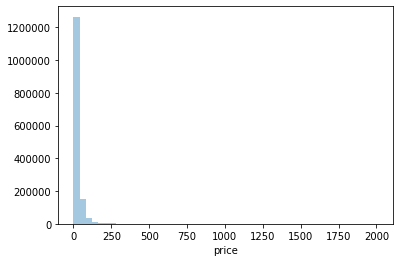

In [3]:
#타겟 값의 데이터 분포 확인
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

y_train_df = mercari_df['price']
plt.figure(figsize = (6,4))
sns.distplot(y_train_df, kde = False) #밀도그래프는 그리지 않는다

낮은 가격을 가진 데이터 값에 왜곡돼있으므로 로그 변환한다.

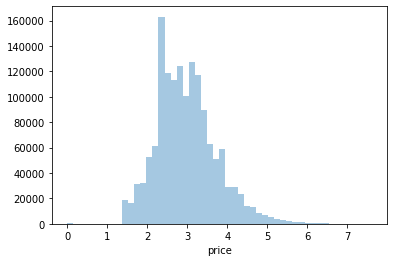

In [4]:
import numpy as np
y_train_df = np.log1p(y_train_df)
sns.distplot(y_train_df, kde = False)

비교적 정규분포에 가까우므로 실제 데이터 셋의 타겟 값도 로그 변환하겠다.

In [5]:
mercari_df['price'].head(3)

0    10.0
1    52.0
2    10.0
Name: price, dtype: float64

In [3]:
import numpy as np
mercari_df['price'] = np.log1p(mercari_df['price'])
mercari_df['price'].head(3)

0    2.397895
1    3.970292
2    2.397895
Name: price, dtype: float64

다른 피쳐 값도 살펴보자.

In [7]:
print('배송비 유형: \n', mercari_df['shipping'].value_counts())
print('\nitem_condition_id 유형 : \n', mercari_df['item_condition_id'].value_counts())

배송비 유형: 
 0    819435
1    663100
Name: shipping, dtype: int64

item_condition_id 유형 : 
 1    640549
3    432161
2    375479
4     31962
5      2384
Name: item_condition_id, dtype: int64


배송비 유무는 비교적 균일한 분포를 띤다. \
item_condition_id는 1,2,3 값이 주를 이룬다.

In [2]:
print('item_description: \n', mercari_df['item_description'].value_counts())

item_description: 
 No description yet                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            82489
New                                                                                                                                                                                                                                                             

In [4]:
#item_description이 뭔지는 모르지만 No descriptioin yet이 얼마나 있는지 확인
boolean_cond = mercari_df['item_description'] == 'No description yet' #해당 인덱스
mercari_df[boolean_cond]['item_description'].count()

82489

In [5]:
boolean_cond = mercari_df['item_description'] == 'No description yet' #해당 인덱스
mercari_df.loc[boolean_cond,'item_description'] = "Other_Null"

In [12]:
mercari_df['item_description'].value_counts()

Other_Null                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    82489
New                                                                                                                                                                                                                                                                                 

In [30]:
mercari_df['category_name'].value_counts()

Women/Athletic Apparel/Pants, Tights, Leggings    60177
Women/Tops & Blouses/T-Shirts                     46380
Beauty/Makeup/Face                                34335
Beauty/Makeup/Lips                                29910
Electronics/Video Games & Consoles/Games          26557
                                                  ...  
Handmade/Children/Furniture                           1
Handmade/Furniture/Other                              1
Handmade/Holidays/New Years                           1
Handmade/Holidays/Patriotic                           1
Kids/Safety/Crib Netting                              1
Name: category_name, Length: 1287, dtype: int64

카테고리명은 대분류, 중분류, 소분류를 '/'로 구분하여 하나의 문자열로 나타내고 있다. 따라서 해당 문자열을 대/중/소로 분리하고 널값을 처리하자.

In [34]:
mercari_df['category_name'][0].split("/")

['Men', 'Tops', 'T-shirts']

In [6]:
def split_cat(category_name):
    try:
        return category_name.split('/')
    except:
        return ['Other_Null', 'Other_Null', 'Other_Null']
    
#분리하여 대중소로 각각 저장
mercari_df['cat_dae'], mercari_df['cat_jung'], mercari_df['cat_so'] = \
    zip(*mercari_df['category_name'].apply(lambda x : split_cat(x)))

zip과 * 함수를 함께 사용하는 이유

In [54]:
p = [[1,2,3],[4,5,6]]

list(zip(p))

[([1, 2, 3],), ([4, 5, 6],)]

In [55]:
list(zip(*p))

[(1, 4), (2, 5), (3, 6)]

In [42]:
mercari_df['category_name'][:10].apply(lambda x : split_cat(x))

0                                [Men, Tops, T-shirts]
1    [Electronics, Computers & Tablets, Components ...
2                      [Women, Tops & Blouses, Blouse]
3               [Home, Home Décor, Home Décor Accents]
4                          [Women, Jewelry, Necklaces]
5                                [Women, Other, Other]
6                         [Women, Swimwear, Two-Piece]
7                  [Sports & Outdoors, Apparel, Girls]
8                  [Sports & Outdoors, Apparel, Girls]
9         [Vintage & Collectibles, Collectibles, Doll]
Name: category_name, dtype: object

In [56]:
list(zip(mercari_df['category_name'][:10].apply(lambda x : split_cat(x))))

[(['Men', 'Tops', 'T-shirts'],),
 (['Electronics', 'Computers & Tablets', 'Components & Parts'],),
 (['Women', 'Tops & Blouses', 'Blouse'],),
 (['Home', 'Home Décor', 'Home Décor Accents'],),
 (['Women', 'Jewelry', 'Necklaces'],),
 (['Women', 'Other', 'Other'],),
 (['Women', 'Swimwear', 'Two-Piece'],),
 (['Sports & Outdoors', 'Apparel', 'Girls'],),
 (['Sports & Outdoors', 'Apparel', 'Girls'],),
 (['Vintage & Collectibles', 'Collectibles', 'Doll'],)]

In [57]:
list(zip(*mercari_df['category_name'][:10].apply(lambda x : split_cat(x))))

[('Men',
  'Electronics',
  'Women',
  'Home',
  'Women',
  'Women',
  'Women',
  'Sports & Outdoors',
  'Sports & Outdoors',
  'Vintage & Collectibles'),
 ('Tops',
  'Computers & Tablets',
  'Tops & Blouses',
  'Home Décor',
  'Jewelry',
  'Other',
  'Swimwear',
  'Apparel',
  'Apparel',
  'Collectibles'),
 ('T-shirts',
  'Components & Parts',
  'Blouse',
  'Home Décor Accents',
  'Necklaces',
  'Other',
  'Two-Piece',
  'Girls',
  'Girls',
  'Doll')]

In [10]:
#분포 확인
print('대분류 유형 : \n', mercari_df['cat_dae'].value_counts())
print('\n중분류 유형 : \n', mercari_df['cat_jung'].value_counts())
print('\n소분류 유형 : \n', mercari_df['cat_so'].value_counts())

대분류 유형 : 
 Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Other_Null                  6327
Name: cat_dae, dtype: int64

중분류 유형 : 
 Athletic Apparel        134383
Makeup                  124624
Tops & Blouses          106960
Shoes                   100452
Jewelry                  61763
                         ...  
Candles                     64
Ceramics and Pottery        57
Dolls and Miniatures        49
Books and Zines             46
Quilts                      31
Name: cat_jung, Length: 114, dtype: int64

소분류 유형 : 
 Pants, Tights, Leggings       60177
Other                         50224
Face                          50171
T-Shirts                      46380
Shoes                         32168
           

In [11]:
print('대분류 유형 :', mercari_df['cat_dae'].nunique())
print('\n중분류 유형 :', mercari_df['cat_jung'].nunique())
print('\n소분류 유형 :', mercari_df['cat_so'].nunique())

대분류 유형 : 11

중분류 유형 : 114

소분류 유형 : 871


널값은 모두 Other Null로 동일하게 변경한다.

In [7]:
mercari_df['brand_name'] = mercari_df['brand_name'].fillna(value = 'Other_Null')
mercari_df['category_name'] = mercari_df['category_name'].fillna(value = 'Other_Null')
mercari_df['item_description'] = mercari_df['item_description'].fillna(value = 'Other_Null')

In [8]:
mercari_df.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
cat_dae              0
cat_jung             0
cat_so               0
dtype: int64

#### 피처 인코딩과 피처 벡터화

각 문자열 칼럼을 살펴보며 어떻게 벡터화할지 선별해보겠다.

In [14]:
print('brand name의 유형 건수 : ', mercari_df['brand_name'].nunique())
print('brand name 유형 예시 : \n', mercari_df['brand_name'].value_counts()[:5] )

brand name의 유형 건수 :  4810
brand name 유형 예시 : 
 Other_Null           632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Name: brand_name, dtype: int64


대부분 명료한 문자열로 되어 있으므로 피처 벡터화를 할 필요가 없을 것으로 보인다. 따라서 별도의 벡터화없이 원-핫 인코딩 변환하겠다.

In [15]:
print('name의 종류 개수 : ', mercari_df['name'].nunique())
print('name 예시 : \n', mercari_df['name'][:10] )

name의 종류 개수 :  1225273
name 예시 : 
 0       MLB Cincinnati Reds T Shirt Size XL
1          Razer BlackWidow Chroma Keyboard
2                            AVA-VIV Blouse
3                     Leather Horse Statues
4                      24K GOLD plated rose
5          Bundled items requested for Ruie
6        Acacia pacific tides santorini top
7      Girls cheer and tumbling bundle of 7
8                     Girls Nike Pro shorts
9    Porcelain clown doll checker pants VTG
Name: name, dtype: object


개별적으로 고유한 상품명을 가지고 있다. 유형이 매우 많고, 적은 단어 위주의 텍스트이므로 카운트 기반 피처 벡터화 변환을 적용하겠다.

category_name 칼럼은 전처리를 통해 대, 중, 소 분류로 나누었다. 따라서 원-핫 인코딩을 적용한다.

shipping 칼럼은 0과 1 두 가지 값, item_condition_id는 1~5 다섯가지 값이므로 원-핫 인코딩을 적용한다.

In [16]:
pd.set_option('max_colwidth', 200)

#item_description의 평균 문자열 크기
print('item_description 평균 문자열 크기:', mercari_df['item_description'].str.len().mean())
mercari_df['item_description'][:2]

item_description 평균 문자열 크기: 145.7113889385411


0                                                                                                                                                                              No description yet
1    This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.
Name: item_description, dtype: object

item_description 칼럼은 문자열이 비교적 기므로 Tf-idf 변환하겠다.

이제 인코딩과 벡터화를 진행하자.

In [9]:
#name
cnt_vec = CountVectorizer()
X_name = cnt_vec.fit_transform(mercari_df.name)

#item_Description
tfidf_descp = TfidfVectorizer(max_features = 50000, ngram_range = (1,3), stop_words = 'english')
X_descp = tfidf_descp.fit_transform(mercari_df['item_description'])

print('name 벡터화 shape : ', X_name.shape)
print('item_description 벡터화 shape : ', X_descp.shape)

name 벡터화 shape :  (1482535, 105757)
item_description 벡터화 shape :  (1482535, 50000)


반환된 데이터는 희소 행렬 형태이므로 다른 칼럼들의 인코딩도 희소 행렬 형태로 적용되어야 한다. 이를 위해 사이킷런의 LabelBinarizer 클래스의 sparse_out = True 속성을 이용한다.\
개별 칼럼들의 희소 행렬은 사이파이 패키지 sparse 모듈의 hstack() 함수를 이용해 결합한다.
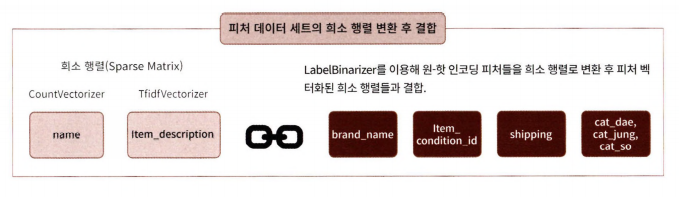

In [10]:
from sklearn.preprocessing import LabelBinarizer

# brand_name, item_condition_id, shipping 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_brand_name= LabelBinarizer(sparse_output=True)
X_brand = lb_brand_name.fit_transform(mercari_df['brand_name'])

lb_item_cond_id = LabelBinarizer(sparse_output=True)
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])

lb_shipping= LabelBinarizer(sparse_output=True)
X_shipping = lb_shipping.fit_transform(mercari_df['shipping'])

# cat_dae, cat_jung, cat_so 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_cat_dae = LabelBinarizer(sparse_output=True)
X_cat_dae= lb_cat_dae.fit_transform(mercari_df['cat_dae'])

lb_cat_jung = LabelBinarizer(sparse_output=True)
X_cat_jung = lb_cat_jung.fit_transform(mercari_df['cat_jung'])

lb_cat_so = LabelBinarizer(sparse_output=True)
X_cat_so = lb_cat_so.fit_transform(mercari_df['cat_so'])

In [11]:
print(type(X_brand), type(X_item_cond_id), type(X_shipping))
print('X_brand_shape:{0}, X_item_cond_id shape:{1}'.format(X_brand.shape, X_item_cond_id.shape))
print('X_shipping shape:{0}, X_cat_dae shape:{1}'.format(X_shipping.shape, X_cat_dae.shape))
print('X_cat_jung shape:{0}, X_cat_so shape:{1}'.format(X_cat_jung.shape, X_cat_so.shape))

<class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'>
X_brand_shape:(1482535, 4810), X_item_cond_id shape:(1482535, 5)
X_shipping shape:(1482535, 1), X_cat_dae shape:(1482535, 11)
X_cat_jung shape:(1482535, 114), X_cat_so shape:(1482535, 871)


인코딩 결과 csr_matrix 타입이며, 유형의 갯수만큼 인코딩 칼럼을 가진다.

이제 각 데이터셋들을 hstack()을 이용해 결합해보자. 메모리를 많이 잡아먹으므로 확인만 하고 삭제한다.

In [20]:
from  scipy.sparse import hstack
import gc

sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id,
            X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

# 사이파이 sparse 모듈의 hstack 함수를 이용하여 앞에서 인코딩과 Vectorization을 수행한 데이터 셋을 모두 결합. 
X_features_sparse= hstack(sparse_matrix_list).tocsr()
print(type(X_features_sparse), X_features_sparse.shape)

# 데이터 셋이 메모리를 많이 차지하므로 사용 용도가 끝났으면 바로 메모리에서 삭제. 
del X_features_sparse
gc.collect()

<class 'scipy.sparse.csr.csr_matrix'> (1482535, 161569)


60

#### 릿지 회귀 모델 구축 및 평가

평가 지표는 캐글에서 제시한 RMSLE를 사용한다. RMSE와 유사하나 오류값에 로그를 취해 높은 가격에서의 오류값이 더 커지는 것을 방지한다.
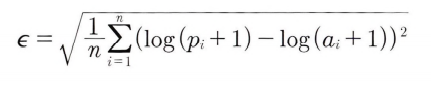

In [12]:
#평가지표 rmsle
def rmsle(y, y_pred):
    return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))

def evaluate_org_price(y_test, preds):
    preds_exmpm = np.expm1(preds)
    y_test_exmpm = np.expm1(y_test)
    #rmsle로 평가
    rmsle_result = rmsle(y_test_exmpm, preds_exmpm)
    return rmsle_result

In [13]:
import gc 
from  scipy.sparse import hstack

def model_train_predict(model,matrix_list):
    # scipy.sparse 모듈의 hstack 을 이용하여 sparse matrix 결합
    X= hstack(matrix_list).tocsr()     
    
    X_train, X_test, y_train, y_test=train_test_split(X, mercari_df['price'], 
                                                      test_size=0.2, random_state=156)
    
    # 모델 학습 및 예측
    model.fit(X_train , y_train)
    preds = model.predict(X_test)
    
    del X , X_train , X_test , y_train 
    gc.collect()
    
    return preds , y_test

예측을 수행하기 전에, item_description과 같은 텍스트 변수가 얼마나 영향을 미치는지 알아보기 위해 두 가지 형태의 변수 모음을 만들자.

In [14]:
linear_model = Ridge(solver = "lsqr", fit_intercept=False)

sparse_matrix_list = (X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds , y_test = model_train_predict(model=linear_model ,matrix_list=sparse_matrix_list)
print('Item Description을 제외했을 때 rmsle 값:', evaluate_org_price(y_test , linear_preds))

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds , y_test = model_train_predict(model=linear_model , matrix_list=sparse_matrix_list)
print('Item Description을 포함한 rmsle 값:',  evaluate_org_price(y_test ,linear_preds))

Item Description을 제외했을 때 rmsle 값: 0.5021728034748326
Item Description을 포함한 rmsle 값: 0.4712208951209407


X_descp 포함시 rmsle 값이 많이 감소하므로 중요한 영향을 끼쳤음을 알 수 있다.

#### LightGBM 회귀 모델 구축 및 앙상블을 이용한 최종 예측 평가

이번엔 LightGBM을 이용해보고, 릿지와 함께 앙상블 방식으로 섞어서 예측 및 평가해보자.

In [24]:
from lightgbm import LGBMRegressor

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

lgbm_model = LGBMRegressor(n_estimators=200, learning_rate=0.5, num_leaves=125, random_state=156)
lgbm_preds , y_test = model_train_predict(model = lgbm_model , matrix_list=sparse_matrix_list)
print('LightGBM rmsle 값:',  evaluate_org_price(y_test , lgbm_preds))

LightGBM rmsle 값: 0.45717396513530145


이렇게 구한 LightGBM의 예측 결과값과 위에서 구한 Ridge의 예측 결과값을 서로 앙상블해 최종 예측 결과값을 도출해보자. LightGBM 결괏값에 0.45를 곱하고 Ridge 결과값에 0.55를 곱한 값을 서로 합해 최종 예측 결과값으로 계산한다. 최적 결과값을 위해서는 다양한 비율로 배합해보면 된다. 

In [25]:
preds = lgbm_preds * 0.45 + linear_preds * 0.55
print('LightGBM과 Ridge를 ensemble한 최종 rmsle 값:',  evaluate_org_price(y_test , preds))

LightGBM과 Ridge를 ensemble한 최종 rmsle 값: 0.45074272898730505
